In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

# Set up visualization settings
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Dataset shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

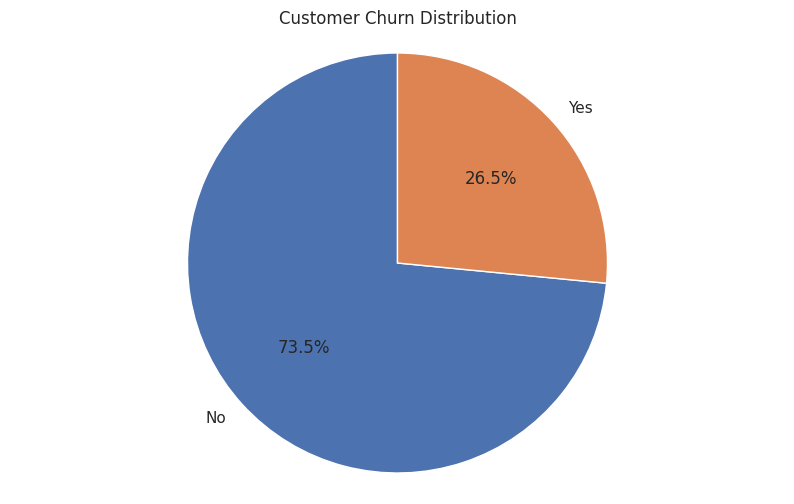


Churn Rate: 26.54%


In [2]:
# Check dataset information
print(f"Dataset shape: {df.shape}")
df.info()

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Explore the target variable distribution
plt.figure(figsize=(10, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Customer Churn Distribution')
plt.axis('equal')
plt.show()

print(f"\nChurn Rate: {churn_counts['Yes'] / len(df) * 100:.2f}%")

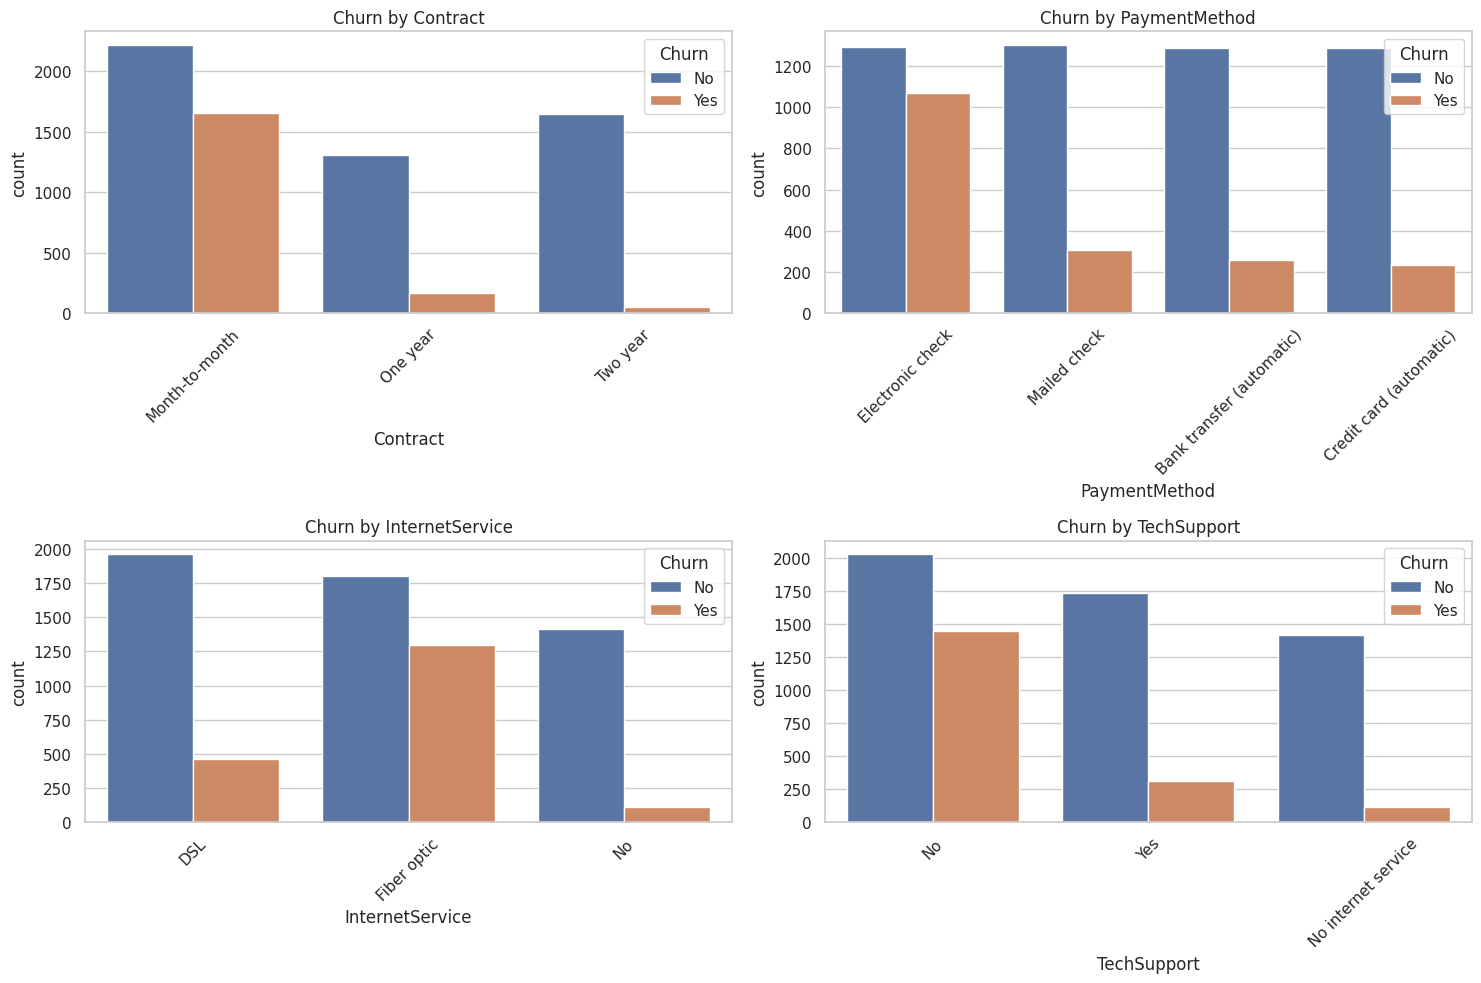

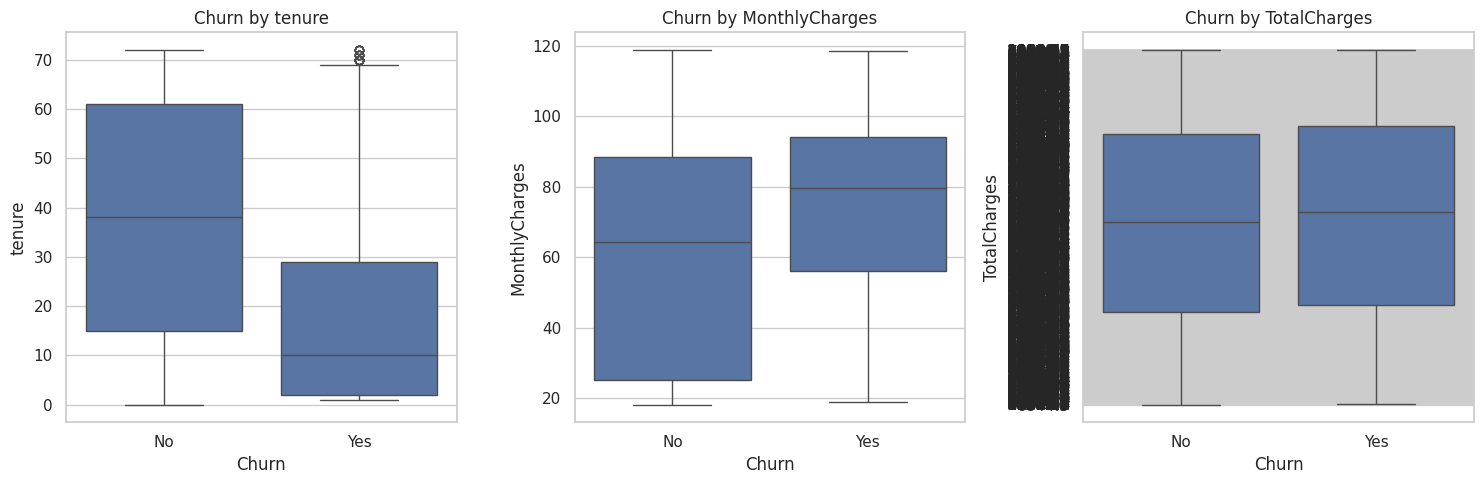

In [3]:
# Categorical feature analysis
plt.figure(figsize=(15, 10))
for i, column in enumerate(['Contract', 'PaymentMethod', 'InternetService', 'TechSupport']):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=column, hue='Churn', data=df)
    plt.title(f'Churn by {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Numerical feature analysis
plt.figure(figsize=(15, 5))
for i, column in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Churn', y=column, data=df)
    plt.title(f'Churn by {column}')
plt.tight_layout()
plt.show()

In [4]:
# Convert TotalCharges to numeric and handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.loc[:, 'TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Create customer tenure groups
def create_tenure_groups(tenure):
    if tenure <= 6:
        return '0-6 months'
    elif tenure <= 12:
        return '7-12 months'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 36:
        return '2-3 years'
    elif tenure <= 48:
        return '3-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'

df['TenureGroup'] = df['tenure'].apply(create_tenure_groups)

# Calculate price sensitivity
df['PriceSensitivity'] = df['MonthlyCharges'] / (df['tenure'] + 1)

# Count total services per customer
service_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

def count_services(row):
    count = 0
    for col in service_columns:
        if row[col] not in ['No', 'No internet service', 'No phone service']:
            count += 1
    return count

df['TotalServices'] = df.apply(count_services, axis=1)

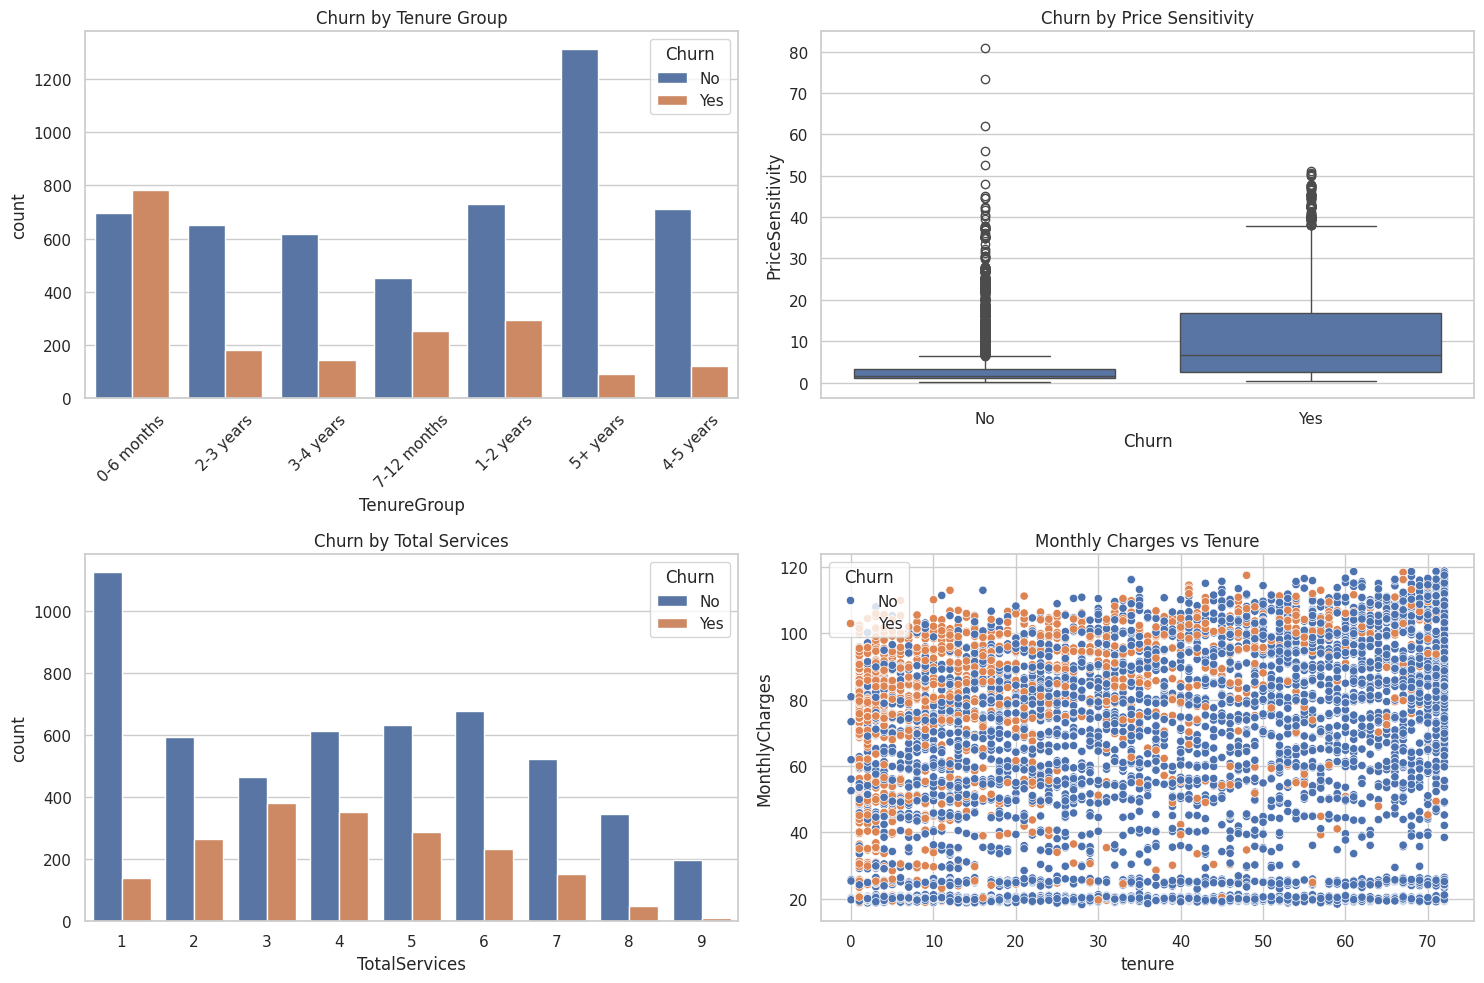

In [5]:
plt.figure(figsize=(15, 10))

# Tenure Group Analysis
plt.subplot(2, 2, 1)
sns.countplot(x='TenureGroup', hue='Churn', data=df)
plt.title('Churn by Tenure Group')
plt.xticks(rotation=45)

# Price Sensitivity Analysis
plt.subplot(2, 2, 2)
sns.boxplot(x='Churn', y='PriceSensitivity', data=df)
plt.title('Churn by Price Sensitivity')

# Total Services Analysis
plt.subplot(2, 2, 3)
sns.countplot(x='TotalServices', hue='Churn', data=df)
plt.title('Churn by Total Services')

# Correlation between Monthly Charges and Tenure
plt.subplot(2, 2, 4)
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df)
plt.title('Monthly Charges vs Tenure')

plt.tight_layout()
plt.show()

In [6]:
# Drop CustomerID if exists
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convert binary columns
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Handle service columns
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in service_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Define columns
categorical_cols = ['gender', 'InternetService', 'Contract', 'PaymentMethod', 'TenureGroup']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'PriceSensitivity', 'TotalServices']

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Create Random Forest model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Model training complete!")

Model training complete!


Model Evaluation:
Accuracy: 0.7828

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.70      2113
weighted avg       0.77      0.78      0.77      2113



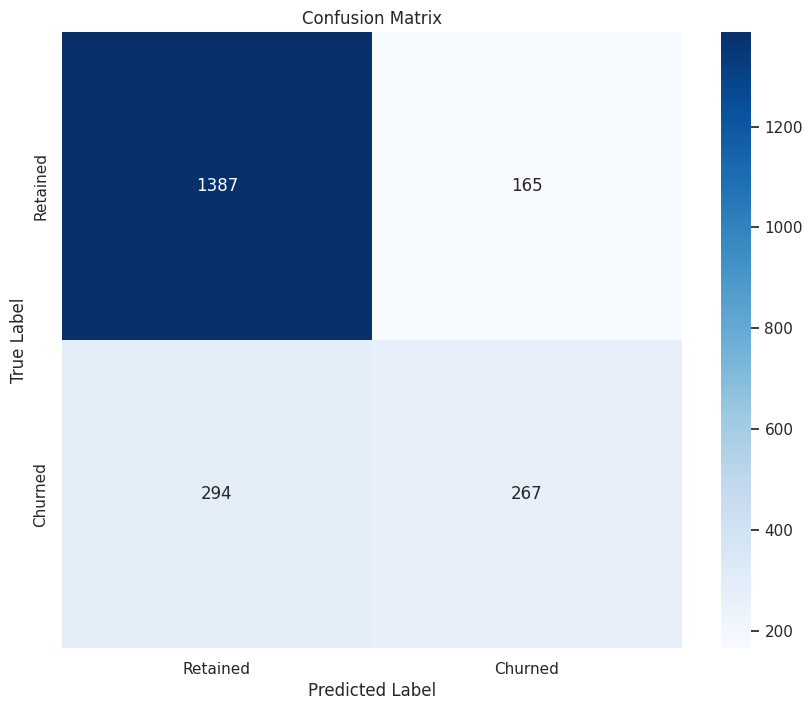

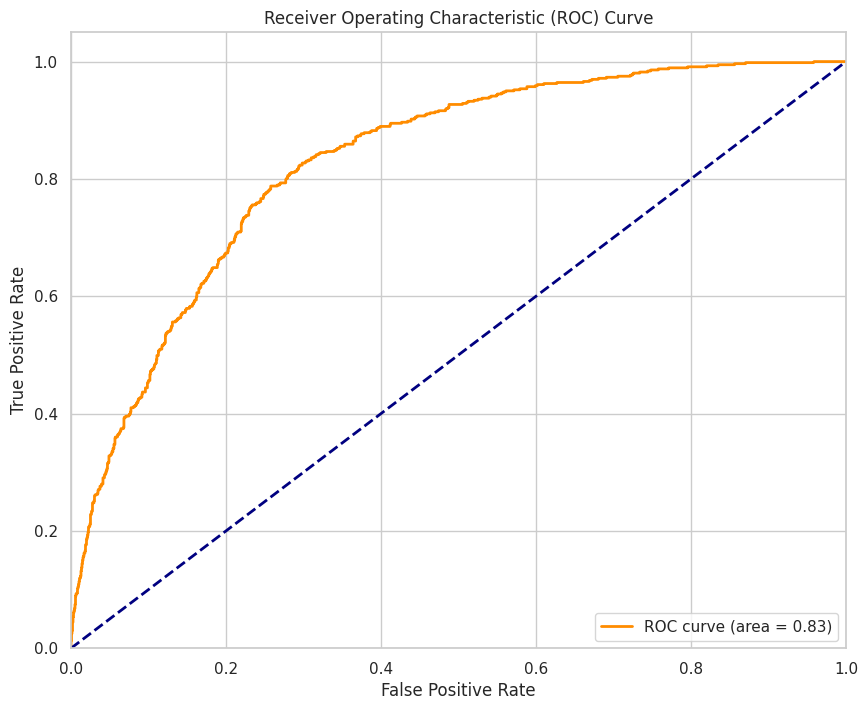

In [8]:
# Evaluate model performance
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

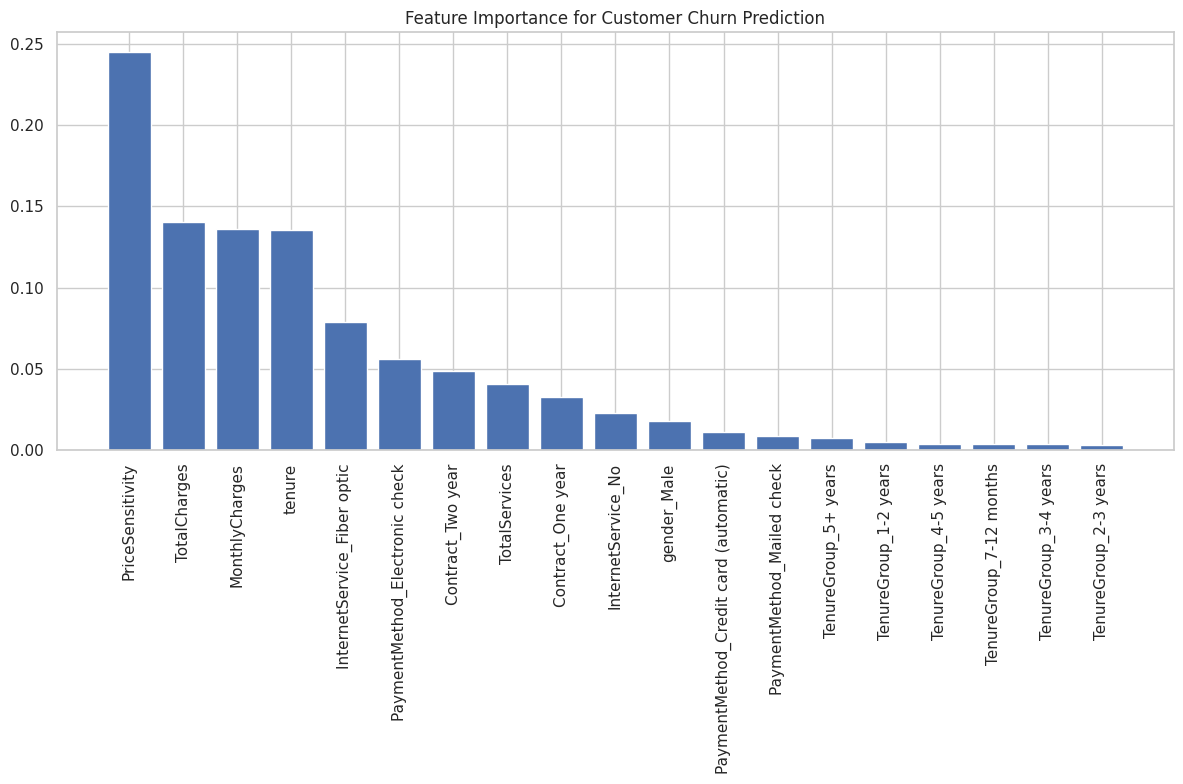

Top 10 most important features:
1. PriceSensitivity: 0.2448
2. TotalCharges: 0.1405
3. MonthlyCharges: 0.1358
4. tenure: 0.1354
5. InternetService_Fiber optic: 0.0785
6. PaymentMethod_Electronic check: 0.0558
7. Contract_Two year: 0.0487
8. TotalServices: 0.0406
9. Contract_One year: 0.0326
10. InternetService_No: 0.0231


In [9]:
# Extract feature importance
if hasattr(model['classifier'], 'feature_importances_'):
    ohe = model['preprocessor'].named_transformers_['cat']
    feature_names = numerical_cols + list(ohe.get_feature_names_out(categorical_cols))

    importances = model['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance for Customer Churn Prediction')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

    print("Top 10 most important features:")
    for i in range(10):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

In [10]:
import plotly.express as px

# Prepare dashboard data
dashboard_data = df.copy()
dashboard_data['PredictedChurn'] = model.predict(X)
dashboard_data['ChurnProbability'] = model.predict_proba(X)[:, 1]

# Create risk categories
def risk_category(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

dashboard_data['RiskCategory'] = dashboard_data['ChurnProbability'].apply(risk_category)

# Risk Distribution Plot
fig1 = px.histogram(dashboard_data, x='ChurnProbability', color='Churn',
                   nbins=50, barmode='overlay',
                   title='Distribution of Churn Probability by Actual Churn Status')
fig1.show()

# Risk by Contract Type
fig2 = px.box(dashboard_data, x='Contract', y='ChurnProbability',
              color='Contract', title='Churn Risk by Contract Type')
fig2.show()

# Risk by Tenure Group
fig3 = px.violin(dashboard_data, x='TenureGroup', y='ChurnProbability',
                color='TenureGroup', box=True, title='Churn Risk by Tenure Group')
fig3.show()

# Risk Category Distribution
risk_counts = dashboard_data['RiskCategory'].value_counts().reset_index()
risk_counts.columns = ['Category', 'Count']
fig4 = px.bar(risk_counts, x='Category', y='Count', title='Customer Risk Distribution')
fig4.show()

# Save high-risk customers
high_risk_customers = dashboard_data[dashboard_data['RiskCategory'] == 'High Risk']
high_risk_customers = high_risk_customers.sort_values('ChurnProbability', ascending=False)
high_risk_customers.to_csv('high_risk_customers.csv', index=False)

print(f"Number of high-risk customers identified: {len(high_risk_customers)}")
print(f"Average churn probability for high-risk customers: {high_risk_customers['ChurnProbability'].mean():.2f}")

Number of high-risk customers identified: 556
Average churn probability for high-risk customers: 0.81


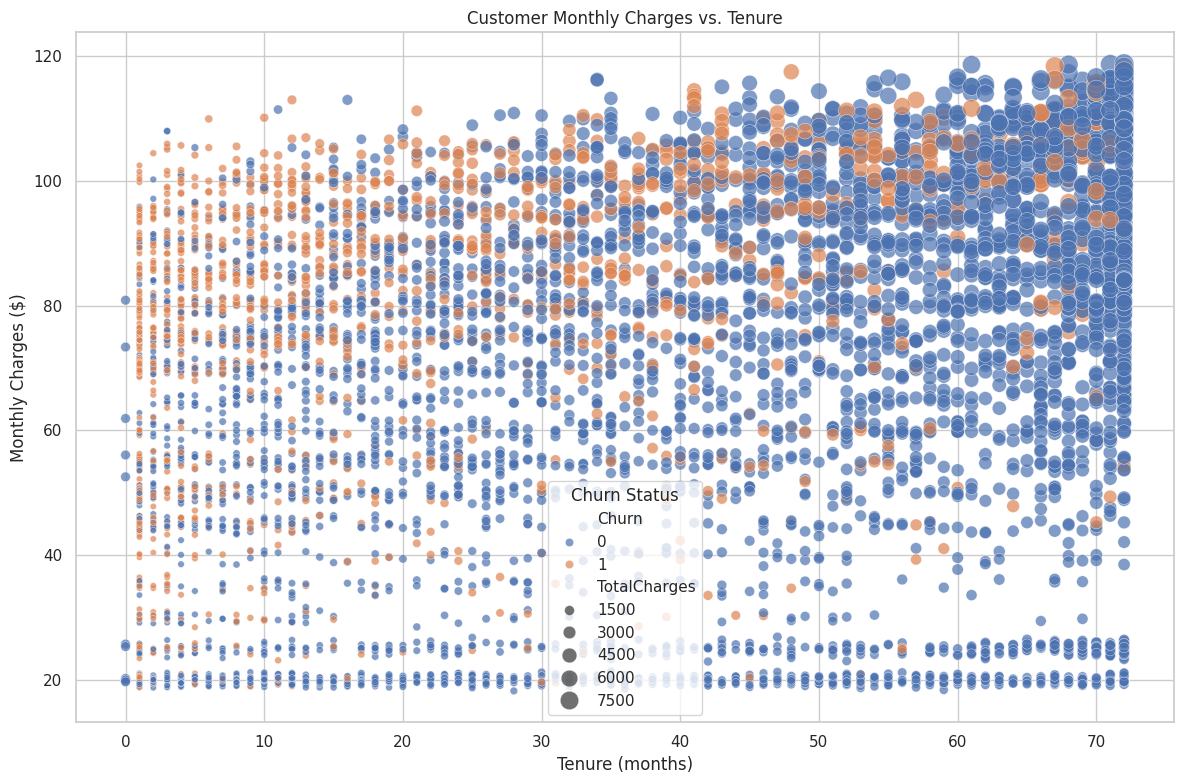

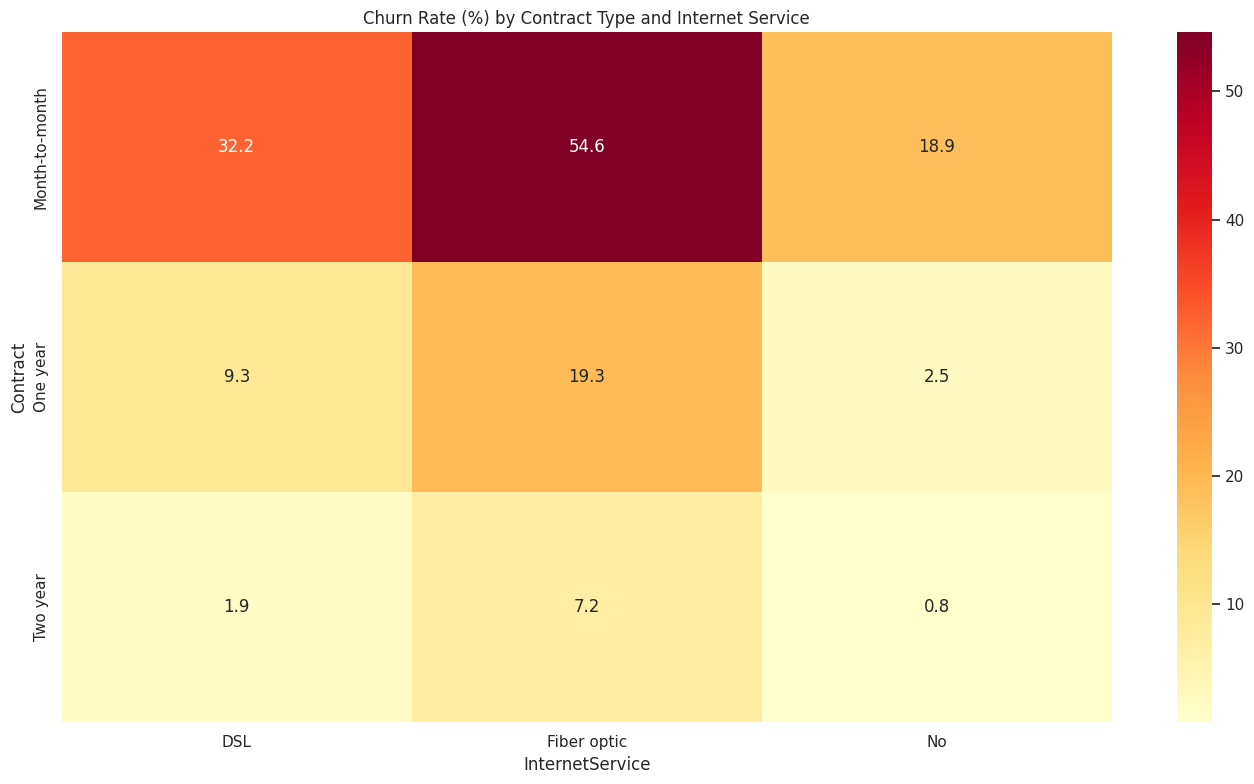

In [11]:
# Monthly Charges vs. Tenure by Churn
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', size='TotalCharges',
               sizes=(20, 200), alpha=0.7, data=df)
plt.title('Customer Monthly Charges vs. Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.legend(title='Churn Status')
plt.tight_layout()
plt.savefig('monthly_charges_vs_tenure.png', dpi=300)
plt.show()

# Churn Rate Heatmap
plt.figure(figsize=(14, 8))
contract_internet_churn = df.groupby(['Contract', 'InternetService'])['Churn'].mean().reset_index()
contract_internet_churn['ChurnRate'] = contract_internet_churn['Churn'] * 100
contract_internet_pivot = contract_internet_churn.pivot(index='Contract',
                                                       columns='InternetService',
                                                       values='ChurnRate')
sns.heatmap(contract_internet_pivot, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Churn Rate (%) by Contract Type and Internet Service')
plt.tight_layout()
plt.savefig('contract_internet_heatmap.png', dpi=300)
plt.show()

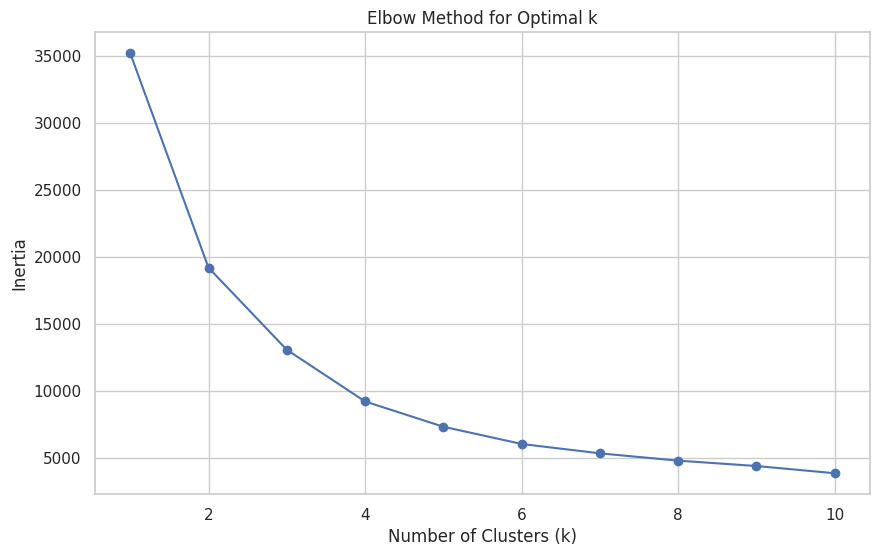

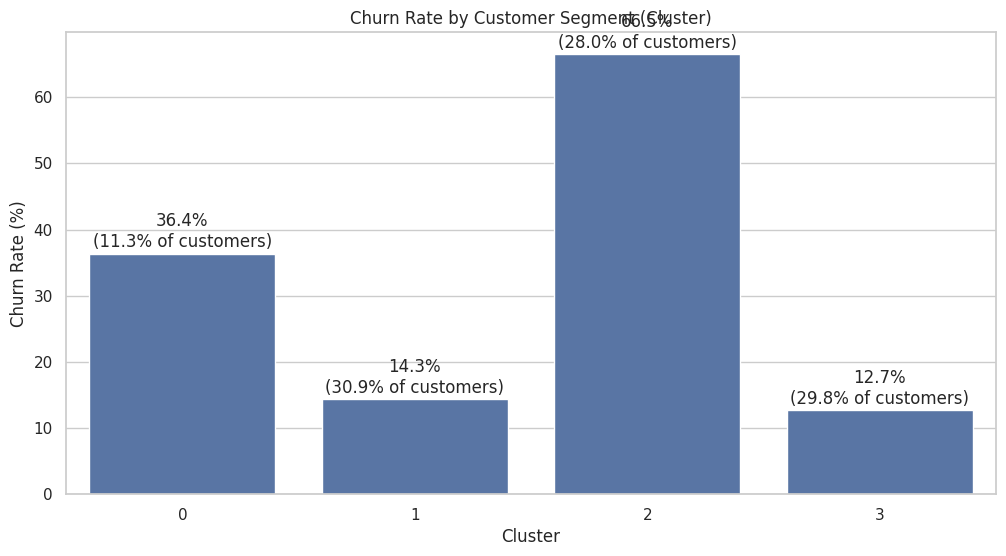

Cluster Profiles:
            tenure  MonthlyCharges  TotalCharges  TotalServices  \
Cluster                                                           
0        22.449701       76.445797   1674.092329       4.620119   
1        60.154080       91.302002   5473.474252       6.715155   
2         1.809824       69.393136    151.802298       3.265743   
3        28.106717       25.944307    718.125869       1.573130   

         PriceSensitivity  
Cluster                    
0                4.778937  
1                1.556398  
2               27.019468  
3                2.722570  


In [12]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Select features for clustering
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'PriceSensitivity']
cluster_data = df[cluster_features].copy()

# Scale data
scaler = StandardScaler()
scaled_cluster_data = scaler.fit_transform(cluster_data)

# Elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_cluster_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_method.png', dpi=300)
plt.show()

# Apply K-means with optimal k
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_cluster_data)

# Analyze churn by cluster
cluster_churn = df.groupby('Cluster')['Churn'].mean() * 100
cluster_size = df['Cluster'].value_counts(normalize=True) * 100
cluster_summary = pd.DataFrame({
    'ChurnRate': cluster_churn,
    'ClusterSize': cluster_size
}).sort_values('ChurnRate', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=cluster_summary.index, y='ChurnRate', data=cluster_summary)
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%\n({cluster_summary["ClusterSize"].iloc[i]:.1f}% of customers)',
                (p.get_x() + p.get_width() / 2., p.get_height() + 1),
                ha='center', va='baseline')
plt.title('Churn Rate by Customer Segment (Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Churn Rate (%)')
plt.savefig('cluster_churn_rate.png', dpi=300)
plt.show()

# Cluster profiles
cluster_profile = df.groupby('Cluster')[cluster_features].mean()
print("Cluster Profiles:")
print(cluster_profile)

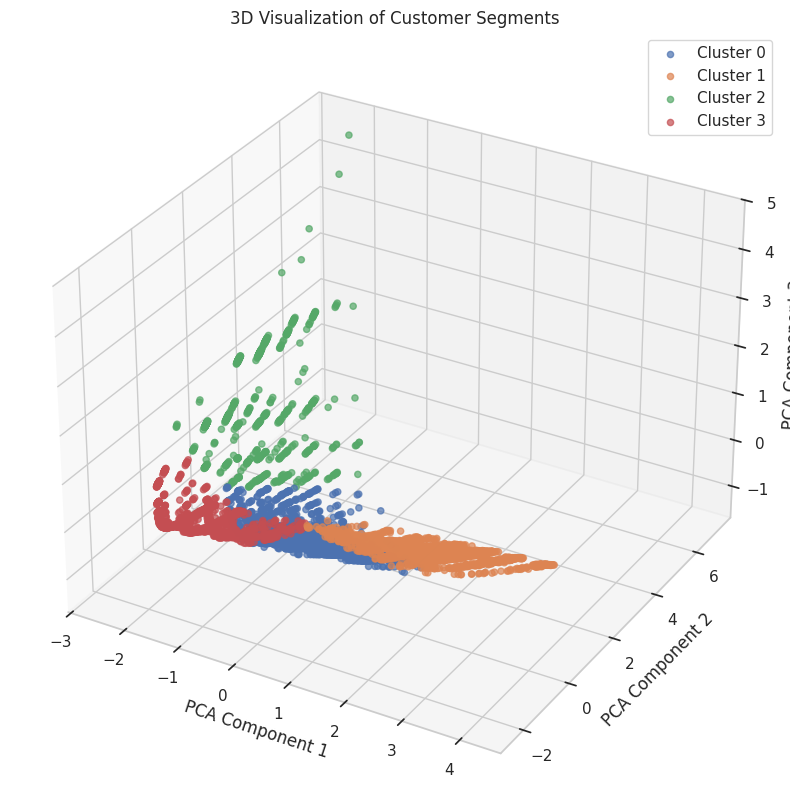

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# PCA for 3D visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_cluster_data)

plot_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3'])
plot_df['Cluster'] = df['Cluster']
plot_df['Churn'] = df['Churn']

# Plot each cluster
for cluster in range(k_optimal):
    cluster_data = plot_df[plot_df['Cluster'] == cluster]
    ax.scatter(cluster_data['PCA1'],
               cluster_data['PCA2'],
               cluster_data['PCA3'],
               label=f'Cluster {cluster}',
               alpha=0.7)

ax.set_title('3D Visualization of Customer Segments')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.savefig('3d_customer_segments.png', dpi=300)
plt.show()

In [14]:
import joblib

# Save the model
joblib.dump(model, 'churn_prediction_model.pkl')
print("Model saved as 'churn_prediction_model.pkl'")

# Prediction function
def predict_churn(customer_data):
    """
    Predict churn probability for a new customer.
    """
    customer_df = pd.DataFrame([customer_data])

    try:
        loaded_model = model
    except:
        loaded_model = joblib.load('churn_prediction_model.pkl')

    churn_prediction = loaded_model.predict(customer_df)[0]
    churn_probability = loaded_model.predict_proba(customer_df)[0, 1]

    risk_level = "Low" if churn_probability < 0.3 else "Medium" if churn_probability < 0.7 else "High"

    return {
        'churn_prediction': bool(churn_prediction),
        'churn_probability': churn_probability,
        'risk_level': risk_level
    }

Model saved as 'churn_prediction_model.pkl'


In [15]:
# Example customer
example_customer = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 1,
    'Dependents': 0,
    'tenure': 24,
    'PhoneService': 1,
    'MultipleLines': 1,
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 0,
    'OnlineBackup': 0,
    'DeviceProtection': 1,
    'TechSupport': 0,
    'StreamingTV': 1,
    'StreamingMovies': 1,
    'Contract': 'Month-to-month',
    'PaperlessBilling': 1,
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 90.45,
    'TotalCharges': 2171.80,
    'TenureGroup': '1-2 years',
    'PriceSensitivity': 3.77,
    'TotalServices': 7
}

prediction_result = predict_churn(example_customer)
print("\nExample Prediction:")
print(f"Churn Prediction: {'Yes' if prediction_result['churn_prediction'] else 'No'}")
print(f"Churn Probability: {prediction_result['churn_probability']:.2f}")
print(f"Risk Level: {prediction_result['risk_level']}")


Example Prediction:
Churn Prediction: No
Churn Probability: 0.46
Risk Level: Medium


In [16]:
import datetime
import json

class ModelMonitor:
    def __init__(self, model_path, log_dir='model_logs'):
        self.model_path = model_path
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

        self.performance_log_path = os.path.join(log_dir, 'performance_log.json')
        if not os.path.exists(self.performance_log_path):
            with open(self.performance_log_path, 'w') as f:
                json.dump([], f)

        self.training_stats_path = os.path.join(log_dir, 'training_stats.json')
        if not os.path.exists(self.training_stats_path):
            self.save_training_stats(X_train)

    def save_training_stats(self, training_data):
        stats = {'numerical_features': {}}

        for col in numerical_cols:
            if col in training_data.columns:
                stats['numerical_features'][col] = {
                    'mean': float(training_data[col].mean()),
                    'std': float(training_data[col].std()),
                    'min': float(training_data[col].min()),
                    'max': float(training_data[col].max())
                }

        with open(self.training_stats_path, 'w') as f:
            json.dump(stats, f, indent=2)

    def evaluate_performance(self, test_data, test_labels):
        predictions = model.predict(test_data)
        probabilities = model.predict_proba(test_data)[:, 1]

        accuracy = accuracy_score(test_labels, predictions)
        auc_score = roc_auc_score(test_labels, probabilities)
        report = classification_report(test_labels, predictions, output_dict=True)

        performance_entry = {
            'timestamp': datetime.datetime.now().isoformat(),
            'accuracy': float(accuracy),
            'auc': float(auc_score),
            'precision': float(report['weighted avg']['precision']),
            'recall': float(report['weighted avg']['recall']),
            'f1_score': float(report['weighted avg']['f1-score']),
            'sample_size': int(len(test_data))
        }

        with open(self.performance_log_path, 'r') as f:
            performance_log = json.load(f)

        performance_log.append(performance_entry)
        with open(self.performance_log_path, 'w') as f:
            json.dump(performance_log, f, indent=2)

        return performance_entry

    def detect_drift(self, new_data, threshold=0.05):
        with open(self.training_stats_path, 'r') as f:
            training_stats = json.load(f)

        drift_detected = False
        drift_report = {}

        for feature in training_stats['numerical_features']:
            if feature in new_data.columns:
                train_mean = training_stats['numerical_features'][feature]['mean']
                new_mean = new_data[feature].mean()
                mean_diff = abs(train_mean - new_mean) / train_mean if train_mean != 0 else abs(new_mean)

                if mean_diff > threshold:
                    drift_detected = True
                    drift_report[feature] = {
                        'metric': 'mean',
                        'training_value': train_mean,
                        'new_value': float(new_mean),
                        'difference_pct': float(mean_diff * 100)
                    }

        return drift_detected, drift_report

# Initialize and test monitor
monitor = ModelMonitor('churn_prediction_model.pkl')
performance = monitor.evaluate_performance(X_test, y_test)

print("Performance metrics logged:")
for metric, value in performance.items():
    if metric != 'timestamp':
        print(f"{metric}: {value}")

# Detect drift
sample_size = min(len(X_test), 500)
drift_detected, drift_report = monitor.detect_drift(X_test.iloc[:sample_size])
print(f"\nData drift detected: {drift_detected}")
if drift_detected:
    print("Drift details:")
    for feature, details in drift_report.items():
        print(f"  {feature}: Training = {details['training_value']:.2f}, New = {details['new_value']:.2f}, Diff = {details['difference_pct']:.2f}%")

Performance metrics logged:
accuracy: 0.7827733080927591
auc: 0.8290963761324587
precision: 0.7701328618837769
recall: 0.7827733080927591
f1_score: 0.7729972005964687
sample_size: 2113

Data drift detected: True
Drift details:
  TotalCharges: Training = 2303.78, New = 2152.25, Diff = 6.58%
  TotalServices: Training = 4.17, New = 3.96, Diff = 5.05%


In [17]:
from sklearn.linear_model import LogisticRegression

def evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    results = {}

    for name, model_clf in models.items():
        print(f"Evaluating {name}...")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_clf)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'accuracy': accuracy,
            'auc': auc_score,
            'pipeline': pipeline
        }

    return results

# Compare models
print("Comparing different machine learning models...")
model_results = evaluate_models(X_train, X_test, y_train, y_test, preprocessor)

# Display results
results_df = pd.DataFrame({
    model_name: {
        'Accuracy': details['accuracy'],
        'AUC': details['auc']
    }
    for model_name, details in model_results.items()
}).T

print("\nModel Comparison:")
print(results_df.sort_values('AUC', ascending=False))

best_model_name = results_df.sort_values('AUC', ascending=False).index[0]
print(f"\nBest model: {best_model_name} with AUC = {results_df.loc[best_model_name, 'AUC']:.4f}")

Comparing different machine learning models...
Evaluating Random Forest...
Evaluating Logistic Regression...

Model Comparison:
                     Accuracy       AUC
Logistic Regression  0.790819  0.839339
Random Forest        0.773781  0.802817

Best model: Logistic Regression with AUC = 0.8393


In [18]:
def create_enhanced_dashboard(data):
    # Risk Distribution
    fig1 = px.histogram(data, x='ChurnProbability', color='Churn',
                   nbins=50, barmode='overlay', opacity=0.7,
                   title='Distribution of Churn Probability by Actual Churn Status',
                   color_discrete_map={0: 'green', 1: 'red'})

    # Risk by Contract
    fig2 = px.box(data, x='Contract', y='ChurnProbability',
              color='Contract', title='Churn Risk by Contract Type')

    # Risk by Tenure
    fig3 = px.violin(data, x='TenureGroup', y='ChurnProbability',
                color='TenureGroup', box=True, title='Churn Risk by Tenure Group')
    fig3.update_layout(xaxis={'categoryorder':'array', 'categoryarray': [
        '0-6 months', '7-12 months', '1-2 years',
        '2-3 years', '3-4 years', '4-5 years', '5+ years'
    ]})

    # Risk Category Distribution
    risk_counts = data['RiskCategory'].value_counts().reset_index()
    risk_counts.columns = ['Category', 'Count']
    risk_counts['Percentage'] = risk_counts['Count'] / risk_counts['Count'].sum() * 100

    fig4 = px.bar(risk_counts, x='Category', y='Count',
               title='Customer Risk Distribution',
               text=risk_counts['Percentage'].apply(lambda x: f'{x:.1f}%'),
               color='Category',
               color_discrete_map={'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'})

    # Correlation Matrix
    corr_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices',
                'PriceSensitivity', 'ChurnProbability']
    corr_matrix = data[corr_cols].corr()

    fig5 = px.imshow(corr_matrix,
                  title='Correlation Matrix of Key Churn Factors',
                  x=corr_cols, y=corr_cols,
                  color_continuous_scale='RdBu_r')

    return fig1, fig2, fig3, fig4, fig5

# Generate visualizations
print("Enhanced Interactive Dashboard")
fig1, fig2, fig3, fig4, fig5 = create_enhanced_dashboard(dashboard_data)

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

# Generate recommendations
def generate_recommendation(row):
    recommendations = []
    if row['Contract'] == 'Month-to-month':
        recommendations.append("Offer contract upgrade incentives")
    if row['InternetService'] == 'Fiber optic' and row['TechSupport'] == 0:
        recommendations.append("Suggest adding Tech Support service")
    if row['tenure'] < 12:
        recommendations.append("Provide early loyalty benefits")
    if row['PriceSensitivity'] > 3:
        recommendations.append("Consider personalized discount")
    return "; ".join(recommendations) if recommendations else "Standard retention outreach"

high_risk_customers = dashboard_data[dashboard_data['RiskCategory'] == 'High Risk'].copy()
high_risk_customers['Recommendations'] = high_risk_customers.apply(generate_recommendation, axis=1)
high_risk_customers.to_csv('high_risk_customers_with_recommendations.csv', index=False)

print(f"\nSaved {len(high_risk_customers)} high-risk customers with recommendations")

Enhanced Interactive Dashboard



Saved 556 high-risk customers with recommendations
